In [14]:
import tensorflow as tf
import numpy as np
import time
import os
#import PIL
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Concatenate
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.backend as K
#import imageio
from IPython import display
print(tf.__version__)
tf.test.is_gpu_available()


2.0.0-beta1


False

W0919 11:31:07.826905 4719961536 training.py:1952] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0919 11:31:11.599653 4719961536 training.py:1952] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Discriminator loss : -11.024621963500977 , Generator loss : 0.18237659335136414


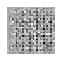

ValueError: Attempt to convert a value (<BatchDataset shapes: ((128, 28, 28, 1), (128, 10)), types: (tf.float32, tf.float32)>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>) to a Tensor.

In [59]:
class W_Cond_GAN :
    
    def __init__(self, img_width, img_height, img_channels, num_classes):
        self.img_width = img_width
        self.img_height = img_height
        self.img_channels = img_channels
        self.num_classes = num_classes
        self.noise_dim = 100
        self.clip_value = 0.01
        self.disc_train_count = 5
        self.discriminator = self.discriminator_model()
        self.discriminator.compile(optimizer=RMSprop(lr=0.0001), loss=self.wasserstein_loss)

        self.generator = self.generator_model()
        noise = Input(shape=(self.noise_dim,))
        labels = Input(shape=(self.num_classes,))
        img_generated = self.generator([noise, labels])
        
        self.discriminator.trainable = False
        
        gan_output = self.discriminator([img_generated, labels])
        self.gan_model = Model(inputs=[noise, labels], outputs=gan_output)
        self.gan_model.compile(optimizer=RMSprop(lr=0.0001), loss=self.wasserstein_loss)
        


    def generator_model(self):
        input_noise = Input(shape=(self.noise_dim,), name='Z_noise')
        class_labels = Input(shape=(self.num_classes), name='Y')
        merged_input = Concatenate()([input_noise, class_labels])

        hidden_vals = Dense(7*7*256)(merged_input)
        hidden_vals = BatchNormalization()(hidden_vals)
        hidden_vals = LeakyReLU()(hidden_vals)
        hidden_vals = Reshape((7,7,256))(hidden_vals)

        hidden_vals = Conv2DTranspose(128, (5,5), strides=(1,1), padding='same')(hidden_vals)
        hidden_vals = BatchNormalization()(hidden_vals)
        hidden_vals = LeakyReLU()(hidden_vals)

        hidden_vals = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same')(hidden_vals)
        hidden_vals = BatchNormalization()(hidden_vals)
        hidden_vals = LeakyReLU()(hidden_vals)

        outputs = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', activation='tanh')(hidden_vals)

        model = Model(inputs=[input_noise, class_labels], outputs=outputs)
        return model
    
    def discriminator_model(self):
        input_image = Input(shape=(self.img_height, self.img_width, self.img_channels,), name='X')
        class_labels = Input(shape=(self.num_classes,), name='Y')

        hidden_vals = Conv2D(64, (5,5), strides=(2,2), padding='same')(input_image)
        hidden_vals = LeakyReLU()(hidden_vals)
        hidden_vals = Dropout(0.3)(hidden_vals)

        hidden_vals = Conv2D(128, (5,5), strides=(2,2), padding='same')(hidden_vals)
        hidden_vals = BatchNormalization()(hidden_vals)
        hidden_vals = LeakyReLU()(hidden_vals)
        hidden_vals = Dropout(0.3)(hidden_vals)

        hidden_vals = Flatten()(hidden_vals)

        merged_with_labels = Concatenate()([hidden_vals, class_labels])
        merged_with_labels = Dense(256, activation='relu')(merged_with_labels)
        outputs = Dense(1)(merged_with_labels)

        model = Model(inputs=[input_image, class_labels], outputs=outputs)
        return model
    
    def wasserstein_loss(self, pred, truth):
        return K.mean(truth * pred)
    
    def clip_gradients(self, model, clip_value):
        for layer in model.layers :
                    weights = layer.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    layer.set_weights(weights)
        return model
    
    # Generates a tensor sampled from a random normal distribution
    def generate_uniform_noise(self, batch_size) :
        return tf.random.normal([batch_size, self.noise_dim],dtype=tf.dtypes.float32)
    
    def one_hot_encode(self, y):
        return tf.reshape(tf.one_hot(y, self.num_classes), (1,self.num_classes))
    
    def generate_img(self, input_noise, input_label, epoch) :
        label_vector = self.one_hot_encode(input_label)
        predictions = self.generator.predict([input_noise,label_vector])
        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        plt.savefig("img_at_epoch_{}.png".format(epoch))
        plt.show()
        
    def generate_sample_labels(self, batch_size):
        sampled_labels = np.random.randint(0, self.num_classes, batch_size)
        return np.array([self.one_hot_encode(x) for x in sampled_labels]).reshape(-1,self.num_classes,)
    
    def train(self, images, labels, epochs, batch_size) :
        buffer_size = images.shape[0]
        random_fixed_noise = self.generate_uniform_noise(1)
        # Reshape to account for greyscales and normalize RGB to [-1,1] as per GoodFellow 2016
        x_train = images.reshape(images.shape[0], 28, 28, 1).astype('float32')
        x_train = (x_train - 127.5)/127.5
        y_train = to_categorical(labels, 10)
        for t in range(epochs):
            start = time.time()
            x_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size).batch(batch_size, drop_remainder=True)
        #    x_train = x_train.take(5)
            for images_mini_batch, labels in x_train :
#                 for train_iter in range(self.disc_train_count) :
                noise = self.generate_uniform_noise(batch_size)
                generated_images = self.generator.predict([noise, labels])

                discr_real_loss = self.discriminator.train_on_batch([images_mini_batch, labels], np.ones((batch_size,1)))
                discr_fake_loss = self.discriminator.train_on_batch([generated_images, labels], -1 * np.ones((batch_size,1)))
                self.discriminator = self.clip_gradients(self.discriminator, self.clip_value)
                    
            random_labels = self.generate_sample_labels(batch_size)
            gen_loss = self.gan_model.train_on_batch([noise, random_labels], np.ones((batch_size,1)))
            print("Discriminator loss : {} , Generator loss : {}".format(discr_real_loss + discr_fake_loss, gen_loss))
            self.generate_img(random_fixed_noise, 1, t)
            
    
                
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_width, img_height = x_train[0].shape
num_classes = 10 
w_cond_gan = W_Cond_GAN(img_width, img_height, 1, num_classes)
w_cond_gan.train(x_train, y_train, 10, 128)   
    

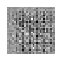

In [70]:
# Generate numbers from the trained generator now
num_to_generate = 0
random_fixed_noise = w_cond_gan.generate_uniform_noise(1)
w_cond_gan.generate_img(random_fixed_noise,num_to_generate, 0)

In [68]:
sampled_labels = np.random.randint(0, 10, 128)
labels_sampled = tf.convert_to_tensor(np.array([w_cond_gan.one_hot_encode(x) for x in sampled_labels]).reshape(-1,10,1))
print(labels_sampled[1] , w_cond_gan.one_hot_encode(y_train[0]))

tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]], shape=(10, 1), dtype=float32) tf.Tensor([[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
